In [1]:
import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')
#from clickhouse_driver.client import Client
import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error


%matplotlib inline

In [2]:
data = "datasets/stock_data.csv"
df = pd.read_csv(data, parse_dates=True)
df.head(10)

,Date,Open,High,Low,Close,Volume,Name
0,1/3/2006,39.69,41.22,38.79,40.91,24232729,AABA
1,1/4/2006,41.22,41.90,40.77,40.97,20553479,AABA
2,1/5/2006,40.93,41.73,40.85,41.53,12829610,AABA
3,1/6/2006,42.88,43.57,42.80,43.21,29422828,AABA
4,1/9/2006,43.10,43.66,42.82,43.42,16268338,AABA
5,1/10/2006,42.96,43.34,42.34,42.98,16288580,AABA
6,1/11/2006,42.19,42.31,41.72,41.87,26192772,AABA
7,1/12/2006,41.92,41.99,40.76,40.89,18921686,AABA
8,1/13/2006,41.00,41.08,39.62,39.90,30966185,AABA
9,1/17/2006,39.09,40.39,38.96,40.11,42429911,AABA


In [3]:

fb = pd.DataFrame(df)
 #, 'Цена при открытии'
fb

,Date,Open,High,Low,Close,Volume,Name
0,1/3/2006,39.69,41.22,38.79,40.91,24232729,AABA
1,1/4/2006,41.22,41.90,40.77,40.97,20553479,AABA
2,1/5/2006,40.93,41.73,40.85,41.53,12829610,AABA
3,1/6/2006,42.88,43.57,42.80,43.21,29422828,AABA
4,1/9/2006,43.10,43.66,42.82,43.42,16268338,AABA
...,...,...,...,...,...,...,...
3014,12/22/2017,71.42,71.87,71.22,71.58,10979165,AABA
3015,12/26/2017,70.94,71.39,69.63,69.86,8542802,AABA
3016,12/27/2017,69.77,70.49,69.69,70.06,6345124,AABA
3017,12/28/2017,70.12,70.32,69.51,69.82,7556877,AABA


In [8]:
df = fb[-700:-200]
df[['Date','Open']]

,Date,Open
2319,3/24/2015,44.64
2320,3/25/2015,44.59
2321,3/26/2015,43.78
2322,3/27/2015,45.20
2323,3/30/2015,45.36
...,...,...
2814,3/10/2017,46.20
2815,3/13/2017,46.10
2816,3/14/2017,46.41
2817,3/15/2017,46.55


In [20]:
df2 = fb[-700:]
df2 = df2[['Date','Open']]
df2

,Date,Open
0,3/24/2015,44.64
1,3/25/2015,44.59
2,3/26/2015,43.78
3,3/27/2015,45.20
4,3/30/2015,45.36
...,...,...
695,12/22/2017,71.42
696,12/26/2017,70.94
697,12/27/2017,69.77
698,12/28/2017,70.12


In [18]:
df = df[['Date', 'Open']]
df

,Date,Open
0,3/24/2015,44.64
1,3/25/2015,44.59
2,3/26/2015,43.78
3,3/27/2015,45.20
4,3/30/2015,45.36
...,...,...
495,3/10/2017,46.20
496,3/13/2017,46.10
497,3/14/2017,46.41
498,3/15/2017,46.55


In [19]:
df2.index = df2.index - 2319
df2.index

RangeIndex(start=0, stop=700, step=1)

In [21]:
class HoltWinters:
    
    """
    Holt-Winters model with the anomalies detection using Brutlag method
    
    # series - initial time series
    # slen - length of a season
    # alpha, beta, gamma - Holt-Winters model coefficients
    # n_preds - predictions horizon
    # scaling_factor - sets the width of the confidence interval by Brutlag (usually takes values from 2 to 3)
    
    """
    
    
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
        
    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  
    
    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # let's calculate season averages
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

          
    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0: # components initialization
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                continue
                
            if i >= len(self.series): # predicting
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
                
                # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                
                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
                     
            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])

In [31]:
from sklearn.model_selection import TimeSeriesSplit # you have everything done for you

def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=25):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=5) 
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen=slen, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

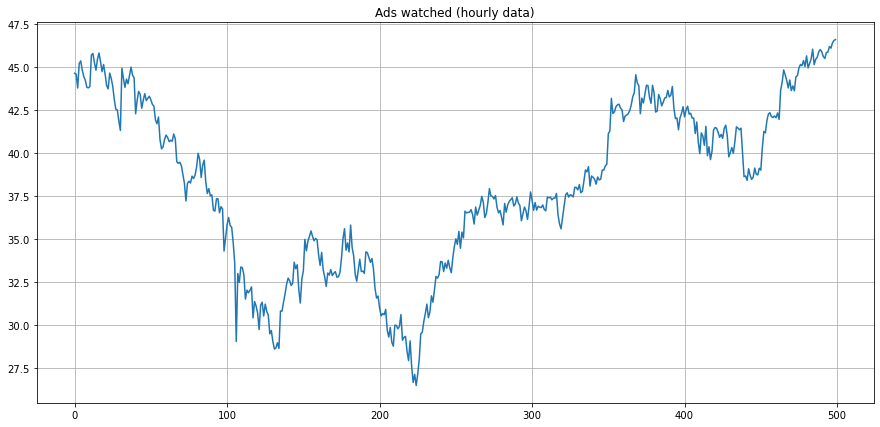

In [27]:
plt.figure(figsize=(15, 7))
plt.plot(df['Open'])
plt.title('Ads watched (hourly data)')
plt.grid(True)
plt.show()

In [24]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [32]:
%%time
data = df['Open']#[:-50] # leave some data for testing
# initializing model parameters alpha, beta and gamma
x = [0, 0, 0] 

# Minimizing the loss function 
opt = minimize(timeseriesCVscore, x0=x, 
               args=(data, mean_absolute_percentage_error), 
               method="TNC", bounds = ((0, 2), (0, 2), (0, 2))
              )

# Take optimal values...
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)



0.11583459450366196 0.021357830195798844 0.49420469771293607
Wall time: 23.4 s


In [52]:
model = HoltWinters(data, slen = 25, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 150, scaling_factor = 3)

model.triple_exponential_smoothing()

In [53]:
def plotHoltWinters(series, plot_intervals=False, plot_anomalies=False):
    """
        series - dataset with timeseries
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    #print(sum(model.result[-31:]))
    plt.figure(figsize=(20, 10))
    plt.plot(model.result, label = "Model")
    plt.plot(df2['Open'], label = "Actual")
    error = mean_absolute_percentage_error(df2['Open'][550:650], model.result[-150:-50])
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    
    if plot_anomalies:
        anomalies = np.array([np.NaN]*len(series))
        anomalies[series.values<model.LowerBond[:len(series)]] = \
            series.values[series.values<model.LowerBond[:len(series)]]
        anomalies[series.values>model.UpperBond[:len(series)]] = \
            series.values[series.values>model.UpperBond[:len(series)]]
        plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    if plot_intervals:
        plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(model.LowerBond, "r--", alpha=0.5)
        plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, 
                         y2=model.LowerBond, alpha=0.2, color = "grey")
        
        
    plt.vlines(len(series), ymin=min(model.LowerBond), ymax=max(model.UpperBond), linestyles='dashed')
    plt.axvspan(len(series)-20, len(model.result), alpha=0.3, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);

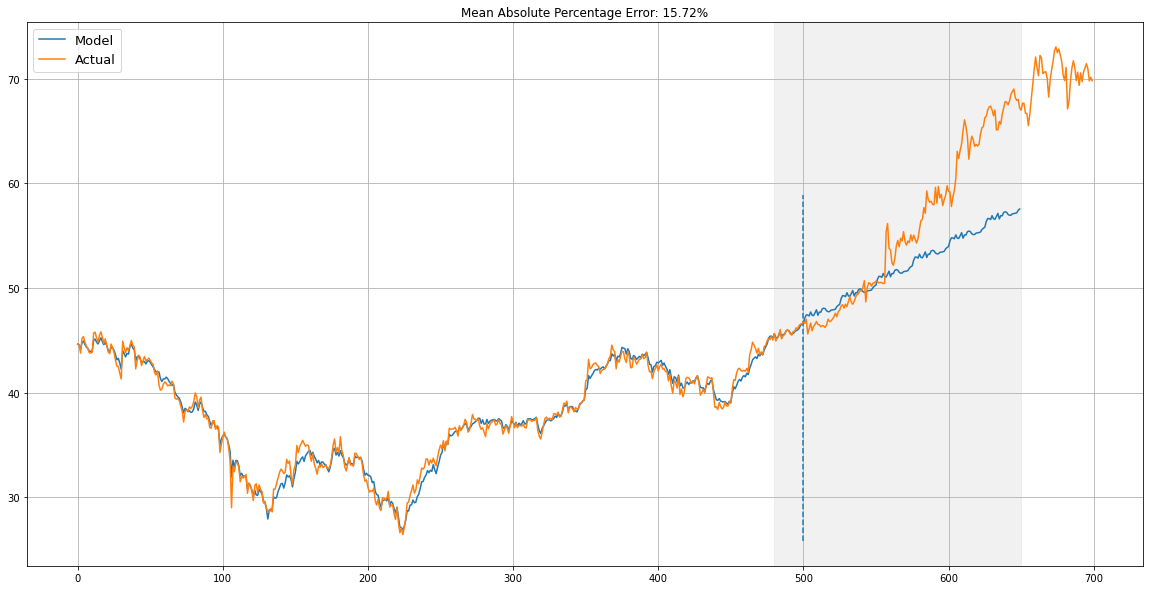

In [54]:
plotHoltWinters(data)

In [ ]:
#print("Fact")
#for i in df['GMV DR'][-85:]:
#    print(str(i).replace('.',','))
    
print("\n\n\nModel")
for i in model.result[-91:]:
    print(str(i).replace('.',','))